In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
%matplotlib inline

In [4]:
ratings = pd.read_csv("../data/ml-latest-small/ratings.csv")
movies = pd.read_csv("../data/ml-latest-small/movies.csv", index_col=0)

In [7]:
%ls ../data/ml-latest-small/

links.csv  movies.csv  ratings.csv  README.txt  tags.csv


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [32]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [8]:
good_ratings = ratings[ratings.rating > 2.4]

In [10]:
good_ratings.shape, ratings.shape

((86619, 4), (100004, 4))

In [43]:
good_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
4,1,1172,4.0,1260759205
8,1,1339,3.5,1260759125


In [39]:
def apply_fun(x):
    x['MovieName'] = movies.title[x.movieId]
    return x

In [60]:
one_user = good_ratings[good_ratings.userId == 1]
one_user['MovieName'] = 'movie'
one_user = one_user.apply(apply_fun, axis=1)
one_user.drop('movieId', axis=1)
one_user.head()

/home/nischal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,userId,movieId,rating,timestamp,MovieName
0,1,31,2.5,1260759144,Dangerous Minds (1995)
1,1,1029,3.0,1260759179,Dumbo (1941)
2,1,1061,3.0,1260759182,Sleepers (1996)
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989)
8,1,1339,3.5,1260759125,Dracula (Bram Stoker's Dracula) (1992)


In [61]:
one_user.sort_values(by='timestamp').head()

,userId,movieId,rating,timestamp,MovieName
17,1,2455,2.5,1260759113,"Fly, The (1986)"
19,1,3671,3.0,1260759117,Blazing Saddles (1974)
8,1,1339,3.5,1260759125,Dracula (Bram Stoker's Dracula) (1992)
10,1,1371,2.5,1260759135,Star Trek: The Motion Picture (1979)
13,1,2105,4.0,1260759139,Tron (1982)


In [67]:
for mid in one_user.movieId.values[:-1]:
    print("{} -> ".format(mid), end="")
print(one_user.movieId.values[-1])

31 -> 1029 -> 1061 -> 1172 -> 1339 -> 1371 -> 1953 -> 2105 -> 2150 -> 2455 -> 3671


In [68]:
groups = good_ratings.sort_values('timestamp').groupby("userId")
max_length = groups.movieId.count().max()
print(max_length)

1997


In [69]:
train_data = []
train_data = np.concatenate((train_data, 
                             groups
                                .apply(
                                    lambda x: np.concatenate(
                                        (x.movieId.values.tolist(), 
                                         np.zeros(max_length - len(x.movieId.values.tolist())))
                                        )
                                    .reshape((-1, 1))
                                    .tolist()
                                )))
train_data = train_data.tolist()

In [74]:
train_data[0][:20]

[[2455.0],
 [3671.0],
 [1339.0],
 [1371.0],
 [2105.0],
 [31.0],
 [1029.0],
 [1061.0],
 [1953.0],
 [2150.0],
 [1172.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0]]

In [75]:
train_data[1][:20]

[[592.0],
 [296.0],
 [590.0],
 [150.0],
 [588.0],
 [153.0],
 [165.0],
 [349.0],
 [292.0],
 [339.0],
 [10.0],
 [161.0],
 [457.0],
 [593.0],
 [253.0],
 [185.0],
 [208.0],
 [300.0],
 [110.0],
 [410.0]]

## Split data into 3 part
<hr>
Now, we split the data into 3 parts, to make mini-batches, so as to learn faster.

In [76]:
d1x, d2x, d3x = pd.split_into_mini_batches(data=train_data, parts=3)

In [81]:
d1x[:15], d2x[:15], d3x[:15]

(array([   1,    5,   12,   23,   44,   75,   82,  118,  122,  163,  219,
         247,  251,  311, 1774]),
 array([   4,   14,   32,  137,  143,  151,  157,  174,  227,  293,  440,
         550, 1797, 2776, 2946]),
 array([   6,   50,   59,  162,  238,  239,  242,  602,  780, 1069, 1538,
        1633, 1805, 2053, 3026]))

## Defining `y` for data 
<hr>

<table>
    <tr>
        <th>X</th>
        <td>0</td>
        <td>1</td>
        <td>2</td>
        <td>3</td>
        <td>4</td>
        <td>5</td>
        <td>6</td>
        <td>7</td>
        <td>8</td>
        <td>9</td>
    <tr>
        <th>y</th>
        <td>1</td>
        <td>2</td>
        <td>3</td>
        <td>4</td>
        <td>5</td>
        <td>6</td>
        <td>7</td>
        <td>8</td>
        <td>9</td>
        <td>0</td>
    </tr>
</table>

In [84]:
d1y = np.append(d1x[1:], d1x[0])
d2y = np.append(d2x[1:], d2x[0])
d3y = np.append(d3x[1:], d3x[0])

In [85]:
d1x[:10], d1y[:10]

(array([  1,   5,  12,  23,  44,  75,  82, 118, 122, 163]),
 array([  5,  12,  23,  44,  75,  82, 118, 122, 163, 219]))

## Define RNN arch

In [102]:
d1x = d1x.reshape(d1x.shape[0], 1, 1)
d2x = d2x.reshape(d2x.shape[0], 1, 1)
d3x = d3x.reshape(d3x.shape[0], 1, 1)

In [90]:
model = Sequential()
model.add(GRU(50, batch_input_shape=(1, d1x.shape[1], d1x.shape[2]), 
               stateful=True, return_sequences=True))
model.add(GRU(100, stateful=True, return_sequences=True))
model.add(GRU(300, stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, 1, 50)                7800      
_________________________________________________________________
gru_2 (GRU)                  (1, 1, 100)               45300     
_________________________________________________________________
gru_3 (GRU)                  (1, 300)                  360900    
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    301       
Total params: 414,301.0
Trainable params: 414,301
Non-trainable params: 0.0
_________________________________________________________________


## Train batches

In [91]:
def train_helper(model, X, y, epochs, log_at, save_path):
    loss_min = 10e10
    loss_history, best_loss = [], []
    for i in range(epochs + 1):
        h = model.fit(X, y, epochs=1, batch_size=1, shuffle=False, verbose=0)
        model.reset_states()
        curr_loss = h.history['loss'][0]
        if curr_loss < loss_min:
            loss_min = curr_loss
            model.save(save_path)
        loss_history.append(curr_loss)
        best_loss.append(loss_min)
        if i % log_at == 0:
            print("Epoch: {}, current_loss: {}, best_loss: {}".format(i, curr_loss, loss_min))
    return loss_history, best_loss

In [ ]:
d1x_loss = []

In [98]:
d1x_loss.extend(train_helper(model=model, X=d1x, y=d1y, epochs=2500, log_at=50, save_path="../models/03_arch_d1x"))

Epoch: 0, current_loss: 75983.57189802329, best_loss: 75983.57189802329
Epoch: 50, current_loss: 42082.6928785334, best_loss: 28517.068221028647
Epoch: 100, current_loss: 33311.34630945921, best_loss: 23634.934136358897
Epoch: 150, current_loss: 229968.40979819297, best_loss: 17137.719854680698
Epoch: 200, current_loss: 17077.079322425525, best_loss: 15995.704264235497
Epoch: 250, current_loss: 90937.87179400325, best_loss: 15002.509977229436
Epoch: 300, current_loss: 58703.2655864122, best_loss: 15002.509977229436
Epoch: 350, current_loss: 17854.080664855243, best_loss: 15002.509977229436
Epoch: 400, current_loss: 13094.798267849286, best_loss: 13094.798267849286
Epoch: 450, current_loss: 8943.683370693525, best_loss: 8943.683370693525
Epoch: 500, current_loss: 164058.91725118956, best_loss: 7070.309858863552
Epoch: 550, current_loss: 195059.471837457, best_loss: 7070.309858863552
Epoch: 600, current_loss: 16295.754888979594, best_loss: 6781.789799114068
Epoch: 650, current_loss: 2798

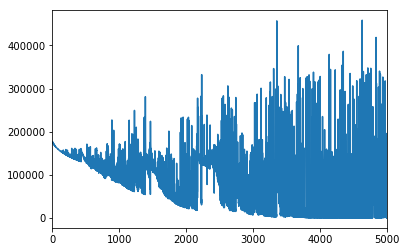

In [99]:
pd.Series(d1x_loss).plot()

In [103]:
d2x_loss, d2x_best_loss = [], []
l, bl = train_helper(model=model, X=d2x, y=d2y, epochs=5000, log_at=100, save_path="../models/03_arch_d(12)x")
d2x_loss.extend(l)
d2x_best_loss.extend(bl)

Epoch: 0, current_loss: 1941775.1653747559, best_loss: 1941775.1653747559
Epoch: 100, current_loss: 143792.79801282883, best_loss: 134930.7893175761
Epoch: 200, current_loss: 117413.4115865181, best_loss: 117211.94766669671
Epoch: 300, current_loss: 367134.04100644606, best_loss: 92489.49698757852
Epoch: 400, current_loss: 622176.3802342336, best_loss: 71146.72282031979
Epoch: 500, current_loss: 55704.38147269885, best_loss: 55405.2978009065
Epoch: 600, current_loss: 580032.9168052654, best_loss: 44043.328263154624
Epoch: 700, current_loss: 103983.64175868829, best_loss: 27750.408755811553
Epoch: 800, current_loss: 580511.6022669707, best_loss: 24234.369802034165
Epoch: 900, current_loss: 13298.69968989889, best_loss: 13298.69968989889
Epoch: 1000, current_loss: 7976.3992061297095, best_loss: 7728.707488904397
Epoch: 1100, current_loss: 488987.31438494025, best_loss: 4764.267130880555
Epoch: 1200, current_loss: 3625.956528568268, best_loss: 3625.956528568268
Epoch: 1300, current_loss: 

ValueError: too many values to unpack (expected 2)

In [105]:
from keras.models import load_model

In [112]:
model = load_model("../models/03c_d2_model")

In [113]:
model.predict(d2x, batch_size=1)

array([[  13.97253418],
       [  31.26633072],
       [ 136.77227783],
       [ 142.64790344],
       [ 150.67861938],
       [ 156.82058716],
       [ 173.71002197],
       [ 226.90032959],
       [ 292.96325684],
       [   3.65987277],
       [  83.32308197],
       [  78.31207275],
       [  83.35202026],
       [  80.6697998 ],
       [  87.53203583]], dtype=float32)

In [111]:
d2y

array([  14,   32,  137,  143,  151,  157,  174,  227,  293,  440,  550,
       1797, 2776, 2946,    4])